In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder,StandardScaler,OneHotEncoder
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer

In [2]:
data = pd.read_csv(r"../data/Custom_Crops_yield_Historical_Dataset.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50765 entries, 0 to 50764
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Dist Code                  50765 non-null  int64  
 1   Year                       50765 non-null  int64  
 2   State Code                 50765 non-null  int64  
 3   State Name                 50765 non-null  object 
 4   Dist Name                  50765 non-null  object 
 5   Crop                       50765 non-null  object 
 6   Area_ha                    50765 non-null  float64
 7   Yield_kg_per_ha            50765 non-null  float64
 8   N_req_kg_per_ha            50765 non-null  float64
 9   P_req_kg_per_ha            50765 non-null  float64
 10  K_req_kg_per_ha            50765 non-null  float64
 11  Total_N_kg                 50765 non-null  float64
 12  Total_P_kg                 50765 non-null  float64
 13  Total_K_kg                 50765 non-null  flo

In [3]:
dataset = data.drop(["State Code","Dist Code","Total_N_kg","Total_P_kg","Total_K_kg"],axis=1)

In [4]:
dataset.columns = dataset.columns.str.strip().str.lower().str.replace(" ", "_")

In [5]:
x = dataset.drop("yield_kg_per_ha",axis=1)
y = dataset["yield_kg_per_ha"]

In [6]:
cat_cols=["state_name","dist_name","crop"]
num_cols=[x for x in x.columns if x not in cat_cols]

In [7]:
encoder = OneHotEncoder(handle_unknown="ignore",sparse_output=False)
encoded_cat = pd.DataFrame(
    encoder.fit_transform(x[cat_cols]),
    columns=encoder.get_feature_names_out(cat_cols),
    index=x.index
)

In [8]:
scaler = StandardScaler()
scaled_num = pd.DataFrame(
    scaler.fit_transform(x[num_cols]),
    columns=num_cols,
    index=x.index
)

In [9]:
x_processed = pd.concat([encoded_cat,scaled_num],axis=1)

In [10]:
x_train,x_test,y_train,y_test= train_test_split(x_processed,y,test_size=0.2,random_state=47)

In [11]:
models={
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=47),
    "XGBoost": XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=8, random_state=47),
    "Bagging (Linear Regression)": BaggingRegressor(estimator=LinearRegression(), n_estimators=100, random_state=47),
    "Bagging (Decision Tree)": BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=None, random_state=47), n_estimators=100, random_state=47, verbose=0),
}

In [12]:
results = {}
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mse)
    cv_scores = cross_val_score(model, x_train, y_train, cv=5, scoring="r2")

    results[name] = {
        "R2": round(r2, 4),
        "RMSE": round(rmse, 2),
        "CV_R2_Mean": round(cv_scores.mean(), 4),
        "CV_R2_Std": round(cv_scores.std(), 4),
    }

results_df = pd.DataFrame(results).T
print(results_df)

KeyboardInterrupt: 

In [ ]:
sensor_df=pd.read_csv("sensor_Crop_Dataset (1).csv")
dataset=dataset.rename(columns={
    "crop":"Crop",
    "temperature_c": "Temperature_C",
    "humidity_%": "Humidity_%",
    "ph": "pH",
    "rainfall_mm": "Rainfall_mm"})
sensor_df

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall,Crop,Soil_Type,Variety
0,69.074766,53.954402,88.067625,17.261834,72.941652,4.631301,302.842639,Wheat,Clay,Soft Red
1,107.329352,70.102134,32.081067,21.846116,99.361954,4.761658,94.693847,Tomato,Clay,Beefsteak
2,130.634624,67.204533,28.294252,33.246895,81.506836,6.566007,83.563685,Sugarcane,Clay,Co 86032
3,15.169301,87.493181,14.336679,14.396289,59.274465,6.296297,31.508836,Sugarcane,Silt,Co 0238
4,21.881965,89.269712,38.833885,16.773218,51.191584,8.268274,295.193482,Maize,Sandy,Sweet
...,...,...,...,...,...,...,...,...,...,...
19995,15.286598,32.026745,52.276522,30.496937,98.813042,7.549344,238.537544,Rice,Silt,Arborio
19996,29.790472,17.182611,74.772890,40.974020,83.002347,5.895767,333.470901,Wheat,Clay,Durum
19997,25.001919,19.140862,32.719994,29.001299,55.231845,8.230164,119.351274,Wheat,Loamy,Hard Red
19998,74.396171,42.100129,20.669153,22.349399,84.369830,7.878051,385.969414,Wheat,Loamy,Soft Red



🔹 Top correlations with Nitrogen:
Variety_Dent          0.022970
Crop_Potato          -0.018503
Crop_Wheat            0.016543
Variety_Red          -0.016330
Soil_Type_Peaty       0.014122
Variety_Roma         -0.013326
Variety_Yukon Gold   -0.012426
Crop_Rice            -0.011806
Soil_Type_Sandy      -0.010431
Variety_Jasmine      -0.010103
Name: Nitrogen, dtype: float64

🔹 Top correlations with Phosphorus:
Crop_Wheat          0.017958
Variety_Co 86032   -0.016052
Potassium           0.013564
Variety_Sweet      -0.013551
Variety_Durum       0.011332
Soil_Type_Loamy    -0.011098
Variety_Hard Red    0.010704
Crop_Sugarcane     -0.010298
Soil_Type_Peaty     0.009255
Variety_Soft Red    0.007085
Name: Phosphorus, dtype: float64

🔹 Top correlations with Potassium:
Phosphorus            0.013564
Variety_Durum         0.011954
Rainfall              0.008835
Variety_Co 0238       0.007732
Crop_Wheat            0.006889
Variety_Beefsteak    -0.006879
Crop_Potato          -0.006352
Variety_Che

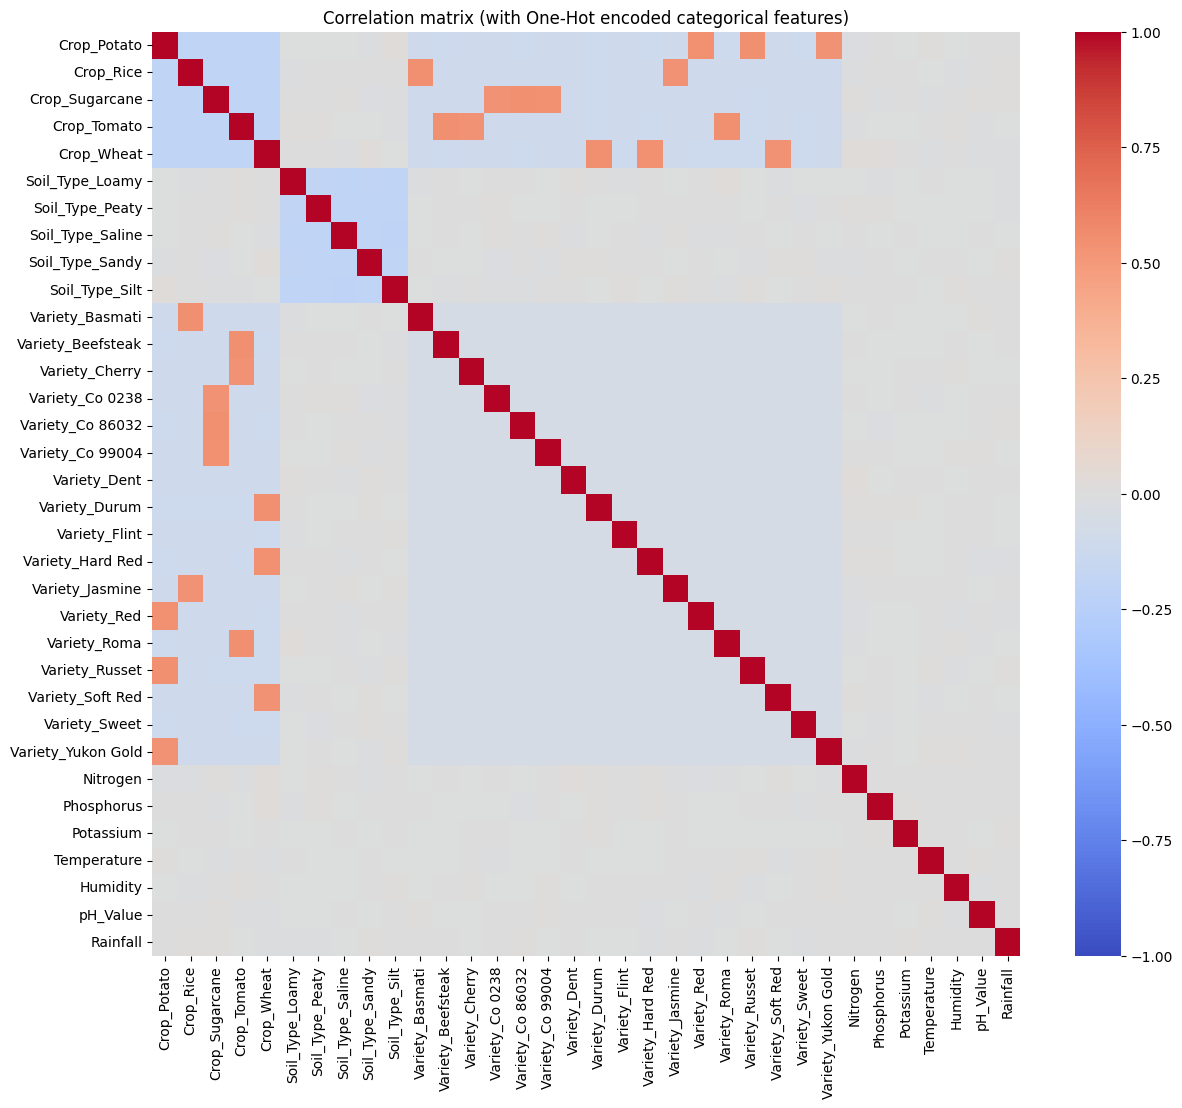

In [ ]:
# 1) choose categorical and numeric cols (auto-detect)
cat_cols = sensor_df.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = sensor_df.select_dtypes(include=[np.number]).columns.tolist()

# 2) OneHotEncode categorical columns
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
ct = ColumnTransformer([("ohe", ohe, cat_cols)], remainder="passthrough")

# 3) fit_transform
arr = ct.fit_transform(sensor_df)

# 4) get feature names from the fitted transformer
ohe_fitted = ct.named_transformers_["ohe"]
ohe_feature_names = ohe_fitted.get_feature_names_out(cat_cols).tolist()
remainder_feature_names = num_cols
feature_names = ohe_feature_names + remainder_feature_names

# 5) build encoded DataFrame
encoded_df = pd.DataFrame(arr, columns=feature_names, index=sensor_df.index)

# 6) convert numeric-looking object columns to numbers
encoded_df = encoded_df.apply(pd.to_numeric, errors="coerce")
# Pick your NPK feature names (adjust to match your dataset)
npk_features = ["Nitrogen", "Phosphorus", "Potassium"]   # <-- change if your dataset has different names like "N_content", "n_kg_per_ha", etc.

# Compute correlations
corr = encoded_df.corr()

# Loop through N, P, K and print top correlated features
for npk in npk_features:
    if npk in corr.columns:
        print(f"\n🔹 Top correlations with {npk}:")
        target_corr = corr[npk].drop(npk).sort_values(key=abs, ascending=False)
        print(target_corr.head(10))  # top 10 correlations
    else:
        print(f"⚠️ Column '{npk}' not found in encoded_df")


# 7) compute correlation matrix


# 8) plot heatmap
plt.figure(figsize=(14,12))
sns.heatmap(corr, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Correlation matrix (with One-Hot encoded categorical features)")
plt.show()

In [ ]:
# Rename columns for consistency
sensor_df = sensor_df.rename(columns={
    "Temperature": "Temperature_C",
    "Humidity": "Humidity_%",
    "pH_Value": "pH",
    "Rainfall": "Rainfall_mm"
})

sensor_df["Crop"] = sensor_df["Crop"].str.strip().str.lower()
dataset["Crop"] = dataset["Crop"].str.strip().str.lower()


sensor_df["Temperature_C"] = sensor_df["Temperature_C"].astype(float)
dataset["Temperature_C"] = dataset["Temperature_C"].astype(float)

sensor_df["Humidity_%"] = sensor_df["Humidity_%"].astype(float)
dataset["Humidity_%"] = dataset["Humidity_%"].astype(float)

sensor_df["pH"] = sensor_df["pH"].astype(float)
dataset["pH"] = dataset["pH"].astype(float)

sensor_df["Rainfall_mm"] = sensor_df["Rainfall_mm"].astype(float)
dataset["Rainfall_mm"] = dataset["Rainfall_mm"].astype(float)

sensor_df["Temperature_C"] = sensor_df["Temperature_C"].round(2)
dataset["Temperature_C"] = dataset["Temperature_C"].round(2)

sensor_df["Humidity_%"] = sensor_df["Humidity_%"].round(2)
dataset["Humidity_%"] = dataset["Humidity_%"].round(2)

sensor_df["pH"] = sensor_df["pH"].round(2)
dataset["pH"] = dataset["pH"].round(2)

sensor_df["Rainfall_mm"] = sensor_df["Rainfall_mm"].round(2)
dataset["Rainfall_mm"] = dataset["Rainfall_mm"].round(2)

# Merge on Crop + environmental features
debug_merge = pd.merge(
    sensor_df,
    dataset,
    on=["Crop", "Temperature_C", "Humidity_%", "pH", "Rainfall_mm"],
    how="outer",
    indicator=True
)
print(debug_merge["_merge"].value_counts())




_merge
right_only    50765
left_only     20000
both              0
Name: count, dtype: int64


In [5]:
import pandas as pd
import numpy as np

# ----------------------------
# Load datasets
# ----------------------------
avail_df = pd.read_csv("fertilizer_dataset.csv")   # available soil NPK + weather + fertilizer advice
req_df = pd.read_csv("Crop_recommendation.csv")  # required NPK for crops

# ----------------------------
# Growth stages and nutrient priorities
# ----------------------------
growth_stages = ["Germination", "Vegetative", "Flowering", "Maturity"]

priority_map = {
    "Germination": {"N": 1.0, "P": 1.5, "K": 0.5},
    "Vegetative": {"N": 1.5, "P": 1.0, "K": 1.0},
    "Flowering":  {"N": 1.2, "P": 1.5, "K": 1.5},
    "Maturity":   {"N": 0.5, "P": 1.0, "K": 1.5}
}

# ----------------------------
# Merge datasets on crop label
# ----------------------------
merged = pd.merge(
    avail_df,
    req_df.rename(columns={"N":"N_req", "P":"P_req", "K":"K_req"}),
    left_on="label",  # fertilizer_dataset crop column
    right_on="label", # crop_recommendation crop column
    how="left"
)

# ----------------------------
# Assign random growth stages
# ----------------------------
np.random.seed(42)
merged["Growth_Stage"] = np.random.choice(growth_stages, size=len(merged))

# ----------------------------
# Add nutrient priorities
# ----------------------------
merged["N_priority"] = merged["Growth_Stage"].map(lambda x: priority_map[x]["N"])
merged["P_priority"] = merged["Growth_Stage"].map(lambda x: priority_map[x]["P"])
merged["K_priority"] = merged["Growth_Stage"].map(lambda x: priority_map[x]["K"])

# ----------------------------
# Compute nutrient demand (req × priority)
# ----------------------------
merged["N_demand"] = merged["N_req"] * merged["N_priority"]
merged["P_demand"] = merged["P_req"] * merged["P_priority"]
merged["K_demand"] = merged["K_req"] * merged["K_priority"]

# ----------------------------
# Compute nutrient differences (demand - available)
# ----------------------------
merged["N_diff"] = merged["N_demand"] - merged["N"]
merged["P_diff"] = merged["P_demand"] - merged["P"]
merged["K_diff"] = merged["K_demand"] - merged["K"]

# ----------------------------
# Final dataset columns
# ----------------------------
final_cols = [
    "label", "Growth_Stage",
    "N_req", "P_req", "K_req",
    "N_priority", "P_priority", "K_priority",
    "N_demand", "P_demand", "K_demand",
    "N", "P", "K",
    "N_diff", "P_diff", "K_diff",
    "temperature", "humidity", "rainfall", "ph",
    "Fertilizer_Advice"
]

final_df = merged[final_cols]

# ----------------------------
# Save to CSV
# ----------------------------
final_df.to_csv("fertilizer_enhanced_dataset.csv", index=False)
print("✅ Enhanced dataset saved as fertilizer_enhanced_dataset.csv")
print(final_df.head())


KeyError: "['temperature', 'humidity', 'rainfall', 'ph'] not in index"

In [5]:
import pandas as pd

# 🔹 Load your dataset (update path as needed)
df = pd.read_csv("Custom_Crops_yield_Historical_Dataset.csv")

# 🔹 Define target column (exclude this one)
# target_column = "irrigation_method"   # change to your target column

# 🔹 Select string/categorical columns except target
cat_cols = ["Crop"]
# if target_column in cat_cols:
#     cat_cols.remove(target_column)

# 🔹 Fetch unique values
unique_entities = {col: df[col].dropna().unique().tolist() for col in cat_cols}

# 🔹 Display results
for col, values in unique_entities.items():
    print(f"\n📌 Column: {col}")
    print(values)



📌 Column: Crop
['rice', 'maize', 'chickpea', 'cotton']
